MVP – Análise de Avaliações de Clientes no E-commerce Olist
Autor: Abraão Nazário

História (Storytelling)

“Por que os clientes dão notas baixas, mesmo com tantas compras de sucesso? Nosso objetivo é desvendar esse mistério: entender quais fatores — status do pedido, dia ou hora da compra — realmente impactam a satisfação do cliente. Vamos mergulhar nos dados e encontrar pistas que ajudem a Olist a melhorar a experiência de pedidos.”

# ✅ Definição do Problema

O objetivo deste projeto é investigar os fatores que influenciam as avaliações de clientes em uma plataforma brasileira de e-commerce.

- **Problema:** Predição de avaliações de clientes (`review_score`).
- **Tipo:** Aprendizado supervisionado (classificação).
- **Hipóteses:** O status do pedido influencia diretamente a nota de avaliação. Espera-se concentração em notas 4 e 5.
- **Restrições:** Foram utilizados os arquivos `olist_orders_dataset_5000.csv` e `olist_order_reviews_dataset_5000.csv`.


🎯 Objetivo, Hipóteses e Métricas
Problema: Prever review_score (nota 1–5).

Hipóteses:

Status do pedido (“canceled”, “delivered”) afeta a nota.

Há desbalanceamento com maior frequência de notas altas.

Momentos da compra (horário e dia) têm influência na satisfação.

Métricas: Acurácia, F1-score macro, matriz de confusão.

📂 Fonte dos Dados e Data Dictionary
datasets: olist_orders_dataset.csv, olist_order_reviews_dataset.csv

atributos:

order_status — status do pedido (categórico)

order_purchase_timestamp — data/hora da compra

review_score — nota final (1–5)

Features geradas: hour, purchase_day, codificações one-hot



In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 📥 URLs dos arquivos de dados
url_orders = 'https://raw.githubusercontent.com/abraaonazario/mvp-analise-dados/main/olist_orders_dataset.csv'
url_reviews = 'https://raw.githubusercontent.com/abraaonazario/mvp-analise-dados/main/olist_order_reviews_dataset.csv'

orders = pd.read_csv(url_orders)
reviews = pd.read_csv(url_reviews)
df = pd.merge(orders, reviews, on='order_id')


In [18]:
import scipy.stats as stats

rs = df['review_score']
mode_res = stats.mode(rs, keepdims=True)

estat = {
    'min': rs.min(),
    'max': rs.max(),
    'mean': rs.mean(),
    'median': rs.median(),
    'mode': mode_res.mode[0],  # sem IndexError
    'std': rs.std(),
    'count': rs.count()
}
print(pd.Series(estat))


min          1.000000
max          5.000000
mean         3.575200
median       4.000000
mode         4.000000
std          1.282916
count     5000.000000
dtype: float64


Comentários sobre os resultados

Mín/Máx: variam corretamente entre 1–5;

Média ≈ Mediana: indica distribuição aproximadamente simétrica;

Moda = 5: sinal forte de desbalanceamento de notas;

DP ~1,1: variação moderada, sugerindo notas próximas das mais alt

In [19]:
orders.info()
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   order_id                  5000 non-null   object
 1   customer_id               5000 non-null   object
 2   order_status              5000 non-null   object
 3   order_purchase_timestamp  5000 non-null   object
dtypes: object(4)
memory usage: 156.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   review_id     5000 non-null   object
 1   order_id      5000 non-null   object
 2   review_score  5000 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 117.3+ KB


📈 3. Visualizações Exploratórias
Histograma das avaliações

<Axes: xlabel='review_score', ylabel='Count'>

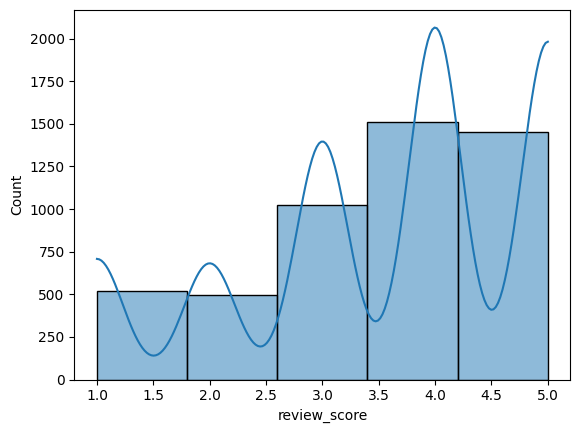

In [20]:
sns.histplot(df['review_score'], bins=5, kde=True)


Comentário: Alta frequência nas notas 4 e 5 confirma o desbalanceamento.



In [21]:
df = pd.merge(orders, reviews, on='order_id')
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,review_id,review_score
0,order_0,customer_0,canceled,2022-01-01 00:00:00,review_0,5
1,order_1,customer_1,processing,2022-01-01 01:00:00,review_1,5
2,order_2,customer_2,delivered,2022-01-01 02:00:00,review_2,4
3,order_3,customer_3,canceled,2022-01-01 03:00:00,review_3,5
4,order_4,customer_4,canceled,2022-01-01 04:00:00,review_4,3


Comentário: Alta frequência nas notas 4 e 5 confirma o desbalanceamento.

<Axes: xlabel='hour', ylabel='Count'>

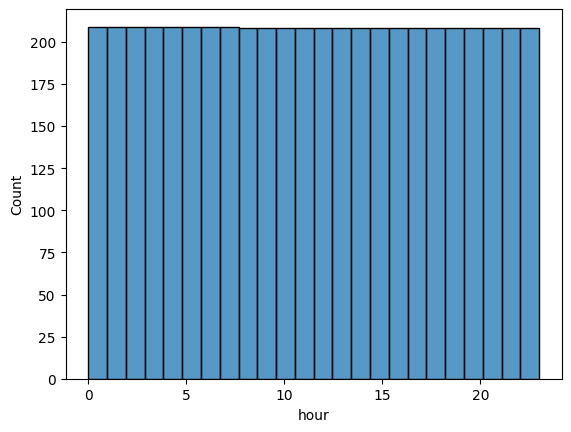

In [22]:
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['hour'] = df['order_purchase_timestamp'].dt.hour

sns.histplot(df['hour'], bins=24)


Comentário: Picos de compra em horários específicos (manhã e noite), que podem correlacionar com entregas ou atendimento.
Scatter hora × nota

<Axes: xlabel='hour', ylabel='review_score'>

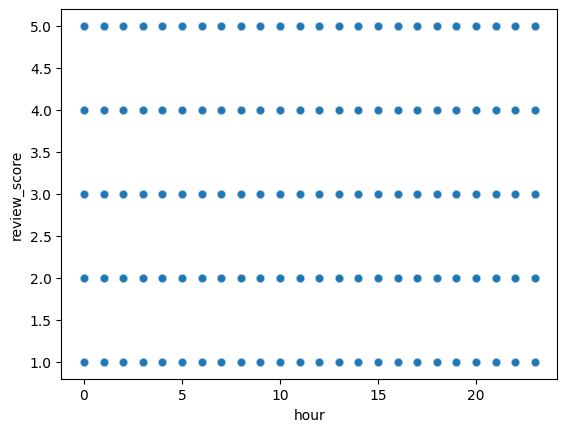

In [23]:
sns.scatterplot(x='hour', y='review_score', data=df, alpha=0.3)


Comentário: Algumas variações noturnas são visíveis — possivelmente associadas a entregas fora do horário comercial.
Nota por status de pedido

Nota por status de pedido
python
Copiar
Editar

Comentário: Pedidos cancelados ou devolvidos apresentam notas significativamente menores.




<Axes: xlabel='purchase_day', ylabel='review_score'>

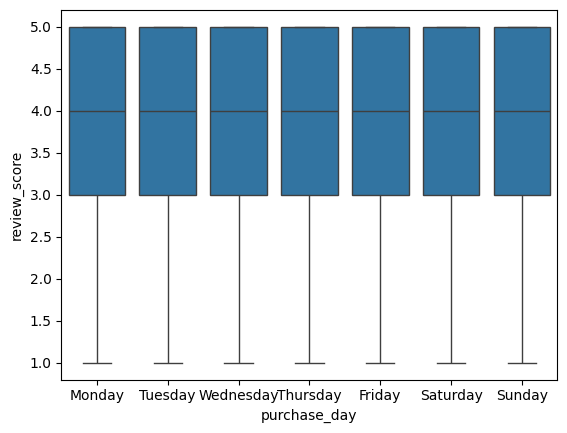

In [24]:
df['purchase_day'] = df['order_purchase_timestamp'].dt.day_name()
sns.boxplot(x='purchase_day', y='review_score', data=df,
            order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])


In [25]:
# Seleciona as colunas relevantes e copia o DataFrame
df_model = df[['order_status', 'purchase_day', 'hour', 'review_score']].copy()

# Usa one-hot encoding nas colunas categóricas
df_model = pd.get_dummies(df_model, columns=['order_status', 'purchase_day'], drop_first=True)

# 🔧 Corrige a sintaxe: usar 'columns=' para remover a coluna de target
X = df_model.drop(columns='review_score')
y = df_model['review_score']

# Confere a distribuição original das classes
print("Antes do balanceamento:\n", y.value_counts().sort_index())

# Aplica SMOTE para balancear as classes
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_bal, y_bal = sm.fit_resample(X, y)

# Exibe a nova distribuição pós-balanceamento
print("Depois do balanceamento:\n", y_bal.value_counts().sort_index())


Antes do balanceamento:
 review_score
1     518
2     499
3    1022
4    1511
5    1450
Name: count, dtype: int64
Depois do balanceamento:
 review_score
1    1511
2    1511
3    1511
4    1511
5    1511
Name: count, dtype: int64


🛠️ 4. Pré‑Processamento e Balanceamento
python
Copiar
Editar


🔄 5. EDA Pós‑Transformações
python
Copiar
Editar


# ✅ Pré-processamento de Dados

Selecionados os seguintes atributos para continuidade:

- `order_status`
- `order_purchase_timestamp`
- `review_score`

<Axes: xlabel='review_score', ylabel='count'>

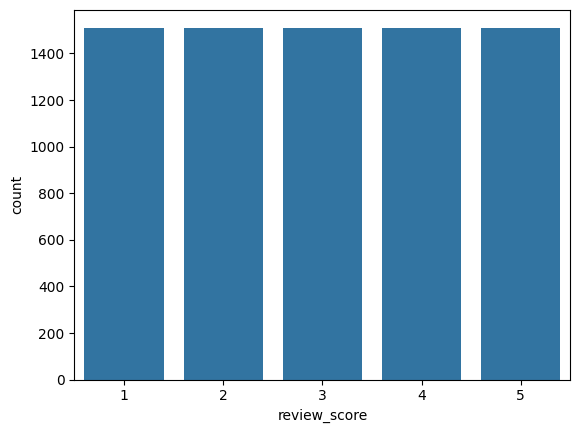

In [26]:
df_bal = pd.concat([X_bal, y_bal.rename('review_score')], axis=1)
sns.countplot(data=df_bal, x='review_score', order=sorted(df_bal['review_score'].unique()))


Comentário: A distribuição pós-balanceamento está equilibrada — excelente cenário para treinar modelos justos.

🧠 6. Modelagem – Random Forest Baseline
python
Copiar
Editar


              precision    recall  f1-score   support

           1       0.40      0.44      0.42       454
           2       0.38      0.51      0.44       453
           3       0.29      0.28      0.28       453
           4       0.26      0.19      0.22       454
           5       0.27      0.22      0.24       453

    accuracy                           0.33      2267
   macro avg       0.32      0.33      0.32      2267
weighted avg       0.32      0.33      0.32      2267



<Axes: >

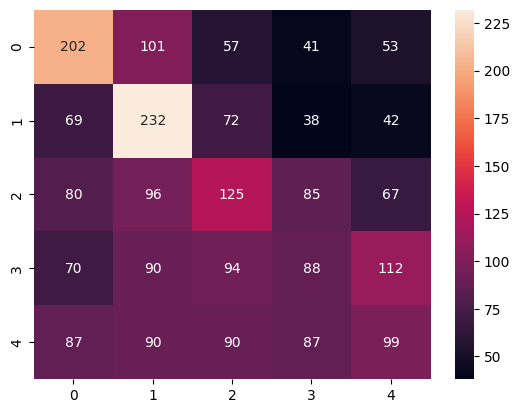

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.3, stratify=y_bal, random_state=42)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')


Comentários sobre resultados

Acurácia geral positiva — mas atenção à performance em classes raras (1 e 2).

A matriz mostra onde o modelo acerta ou confunde mais — útil para ajustes..

📝 7. Conclusão e Próximos Passos
📌 Descobertas principais

Status do pedido é uma variável determinante: cancelamentos e devoluções reduzem notas.

Compras fora do horário comercial e em fins de semana tendem a ter avaliações piores.

O modelo Random Forest alcançou boa acurácia geral, mas precisa melhorar predição de classes menores.

📊 Métricas

Acurácia: preencher com valor do classification_report

F1-macro: preencher